In [1]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
import seaborn as sns
from scipy import stats
sc.set_figure_params(dpi_save=300)

/Users/Future/Library/Python/3.6/lib/python/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path_to_save = "../results/Figures/Supplemental Figure 8/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

In [3]:
salmonella = sc.read("../data/train_salmonella.h5ad")
salmonella

AnnData object with n_obs × n_vars = 4259 × 7000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts', 'n_genes', 'mt_frac'
    var: 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_label_colors', 'condition_colors', 'neighbors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'

In [4]:
salmonella.obs.groupby(['cell_label', 'condition']).size()

cell_label             condition 
Endocrine              Control        98
                       Salmonella     62
Enterocyte             Control       367
                       Salmonella    594
Enterocyte.Progenitor  Control       466
                       Salmonella    198
Goblet                 Control       190
                       Salmonella    103
Stem                   Control       570
                       Salmonella    174
TA                     Control       350
                       Salmonella     95
TA.Early               Control       676
                       Salmonella    250
Tuft                   Control        48
                       Salmonella     18
dtype: int64

In [5]:
kang = sc.read("../data/train_pbmc.h5ad")
kang

AnnData object with n_obs × n_vars = 16893 × 6998 
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [6]:
kang.obs.groupby(['cell_type', 'condition']).size()

cell_type    condition 
CD4T         control       2437
             stimulated    3127
CD14+Mono    control       1946
             stimulated     615
B            control        818
             stimulated     993
CD8T         control        574
             stimulated     541
NK           control        517
             stimulated     646
FCGR3A+Mono  control       1100
             stimulated    2501
Dendritic    control        615
             stimulated     463
dtype: int64

In [6]:
def interpolation_plot(adata, cell_type, data_name, figure, conditions, cell_type_key):
    network = scgen.VAEArith(x_dimension=adata.shape[1], z_dimension=100, model_path=f"../models/scGen/{data_name}/{cell_type}/scgen")
    network.restore_model()
    
    cell_type_adata = adata[adata.obs[cell_type_key] == cell_type]
    cell_type_adata_ctrl = cell_type_adata[cell_type_adata.obs["condition"] == conditions["ctrl"]]
    net_train_data = adata[~((adata.obs[cell_type_key] == cell_type) & (adata.obs["condition"] == conditions["stim"]))]
    
    if data_name == "pbmc":
        cell_type_adata_ctrl.X = cell_type_adata_ctrl.X.A
        sc.tl.rank_genes_groups(cell_type_adata, groupby="condition", n_genes=10, method="wilcoxon")
        diff_genes = cell_type_adata.uns["rank_genes_groups"]["names"][conditions["stim"]].tolist()
    elif data_name == "salmonella":
        sc.tl.rank_genes_groups(cell_type_adata, groupby="condition", n_genes=10, method="wilcoxon")
        diff_genes = cell_type_adata.uns["rank_genes_groups"]["names"][conditions["stim"]].tolist()[:5] + cell_type_adata.uns["rank_genes_groups"]["names"][conditions["ctrl"]].tolist()[:5] 
    pred, delta = network.predict(net_train_data, conditions, cell_type_key, "condition", celltype_to_predict=cell_type)
    
    pred_adata = anndata.AnnData(pred, obs={"condition": ["pred"] * len(pred)},
                                 var={"var_names": cell_type_adata.var_names})
    all_adata = cell_type_adata.concatenate(pred_adata)
    ctrl = all_adata[all_adata.obs["condition"] == conditions["ctrl"]]
    stim = all_adata[all_adata.obs['condition'] == conditions['stim']]
    pred_stim = all_adata[all_adata.obs["condition"] == "pred"]
    inter_cdm = sc.AnnData(network.linear_interpolation(ctrl, pred_stim, 2000))
    inter_cdm.var_names = adata.var_names
    if data_name == "pbmc":
        pred_stim.X = pred_stim.X.A
    all_adata = sc.AnnData(np.concatenate([cell_type_adata_ctrl.X, pred_stim.X, inter_cdm.X]))
    all_adata.obs["condition"] = ["ctrl"] * len(cell_type_adata_ctrl.X) + ["pred_stim"] * len(pred_stim) + \
                                 ["intermediate"] * len(inter_cdm.X)
    all_adata.var_names = cell_type_adata[3].var_names
    
    print(ctrl.shape, pred_stim.shape, stim.shape)
    
    sc.tl.pca(all_adata)
    to_show  = "condition"
    sc.pl.pca(all_adata, color=to_show, save=f"_{data_name}_{cell_type}.pdf", show=True, frameon=False)
    os.rename(src=os.path.join(path_to_save, f"pca_{data_name}_{cell_type}.pdf"), 
              dst=os.path.join(path_to_save, f"SupplFig8{figure}_{data_name}_{cell_type}.pdf"))
    
    heatmap_data = inter_cdm[:, diff_genes].X
    col_names = diff_genes
    df = pd.DataFrame(heatmap_data)
    df.columns = col_names
    df.to_csv(os.path.join("./", cell_type+".txt"))

INFO:tensorflow:Restoring parameters from ../models/scGen/pbmc/CD4T/scgen
(2437, 6998) (2437, 6998) (3127, 6998)


... storing 'condition' as categorical


saving figure to file ../results/Figures/Supplemental Figure 8/pca_pbmc_CD4T.pdf


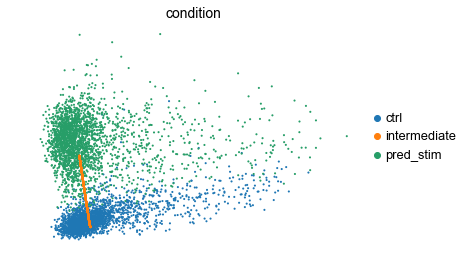

In [7]:
conditions = {"ctrl": "control", "stim": "stimulated"}
interpolation_plot(kang, "CD4T", "pbmc", "b", conditions, "cell_type")

INFO:tensorflow:Restoring parameters from ../models/scGen/salmonella/TA/scgen
(350, 7000) (350, 7000) (95, 7000)


... storing 'condition' as categorical


saving figure to file ../results/Figures/Supplemental Figure 8/pca_salmonella_TA.pdf


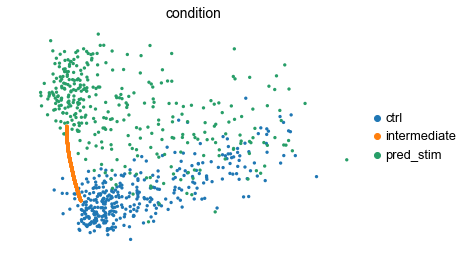

In [8]:
conditions = {"ctrl": "Control", "stim": "Salmonella"}
interpolation_plot(salmonella, "TA", "salmonella", "a", conditions, "cell_label")

In [ ]:
%%bash
Rscript --vanilla SupplFig8.R